# Parallel Computing

## General thoughts

Parallel computing is a programming method that **harnesses the power of multiple processors (typically CPU cores) at once**.

There are many types of parallelism, some of which are (from micro to macro)

* **Instruction level parallelism** (e.g. SIMD)
* **Multi-threading** (shared memory)
* **Multi-processing** (shared system memory)
* **Distributed processing** (typically no shared memory)

**Import note before we start: At the center of an efficient parallel code is a fast serial code!!**

### Why go parallel?

<img src="./imgs/42-years-processor-trend.svg" width=700px>

### When to go parallel?

* If parts of your (optimized!) serial code aren't fast enough.
  * note that parallelization typically increases the code complexity
* If your system has multiple execution units (CPU threads, GPU threads, ...).
  * particularly import on large supercomputers but also already on modern desktop computers and laptops.

### How many CPU threads / cores do I have?

In [1]:
using Hwloc
Hwloc.num_physical_cores()

6

Note that there may be more than one CPU thread per physical CPU core (e.g. hyperthreading).

In [2]:
Sys.CPU_THREADS

12

### How many CPU threads / cores does Hawk have?

[Hawk has about 720k CPU cores!](https://www.hlrs.de/solutions/systems/hpe-apollo-hawk)

Even if you only use a single node you have access to 128 CPU cores (64 per CPU). Hence, if you would use only a single core, the node utilization would be less than 1%.

### Amdahl's law

Naive strong scaling expectation: I have 4 cores, give me my 4x speedup!

>If $p$ is the fraction of a code that can be parallelized than the maximal theoretical speedup by parallelizing on $n$ cores is given by
>$$ F(n) = 1/(1-p + p/n) $$

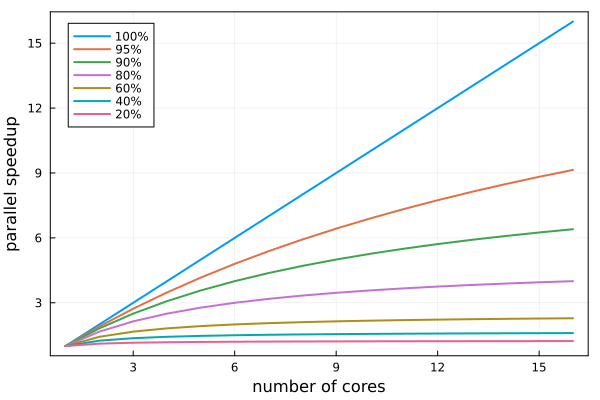

In [3]:
using Plots
F(p,n) = 1/(1-p + p/n)

pl = plot()
for p in reverse(sort(vcat(0.2:0.2:1, [0.9, 0.95])))
    plot!(pl, n -> F(p,n), 1:16, lab="$(Int(p*100))%", lw=2,
        legend=:topleft, xlab="number of cores", ylab="parallel speedup", frame=:box)
end
pl

### [Parallel computing](https://docs.julialang.org/en/v1/manual/parallel-computing/) in Julia

Julia provides support for all types of parallelism mentioned above (same order)

* `@simd`, [SIMD.jl](https://github.com/eschnett/SIMD.jl), [LoopVectorization.jl](https://github.com/JuliaSIMD/LoopVectorization.jl)
* `Threads.@threads`, `Threads.@spawn`, [FLoops.jl](https://github.com/JuliaFolds/FLoops.jl), [ThreadsX.jl](https://github.com/tkf/ThreadsX.jl) ...
* `@spawnat`, `@fetch`, `SharedArray`
* `@spawnat`, `@fetch`, `RemoteChannel`, [DistributedArrays.jl](https://github.com/JuliaParallel/DistributedArrays.jl), [MPI.jl](https://github.com/JuliaParallel/MPI.jl)

With supercomputing in mind, we will start by focusing on multi-process parallelism which allows us to utilize multiple cores on the same or different nodes/machines (distributed computing).

But before we do, it's instructive to take a closer look at **tasks**.